In [ ]:
# Install Kaggle and authenticate
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Select the 'kaggle.json' file downloaded from Kaggle

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aioshichowdhury","key":"c403ded3833a021f35813c9d0325a1f7"}'}

In [ ]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d suryaprabhakaran2005/road-accidents-from-cctv-footages-dataset

Dataset URL: https://www.kaggle.com/datasets/suryaprabhakaran2005/road-accidents-from-cctv-footages-dataset
License(s): MIT
100% 667M/670M [00:25<00:00, 32.3MB/s]
100% 670M/670M [00:25<00:00, 27.1MB/s]


In [ ]:
# Unzip the dataset
!unzip road-accidents-from-cctv-footages-dataset.zip -d /content/AccidentDataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/387.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/388.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/389.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/39.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/390.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/391.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/392.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/393.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/394.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severit

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [ ]:
# Constants
IMG_SIZE = 128
ColorChannels = 3
CLASSES = ["NonAccident", "Accident"]

In [ ]:
#checking for the number of video
import os

# Directory setup
video_data_dir = '/content/AccidentDataset'
accident_dir = os.path.join(video_data_dir, 'Accident', 'Accident')
# The following line has been changed.
non_accident_dir = os.path.join(video_data_dir, 'NonAccident', 'NonAccident') # Remove extra 'Accident' from the path

# # Paths to the directories containing accident and non-accident videos
# accident_dir = '/content/AccidentDataset/Accident/Accident'
# non_accident_dir = '/content/AccidentDataset/Accident/NonAccident'

# Count videos in each class
num_accident_videos = len([file for file in os.listdir(accident_dir) if file.endswith(('.mp4', '.avi', '.mov','.jpg'))])
num_non_accident_videos = len([file for file in os.listdir(non_accident_dir) if file.endswith(('.mp4', '.avi', '.mov','.jpg'))])

print(f"Number of Accident videos: {num_accident_videos}")
print(f"Number of Non-Accident videos: {num_non_accident_videos}")

Number of Accident videos: 6191
Number of Non-Accident videos: 7710


In [ ]:
import os
import random

# Directory containing the Non-Accident images
non_accident_dir = '/content/AccidentDataset/NonAccident/NonAccident'

# Get a list of all .jpg files in the directory
jpg_files = [file for file in os.listdir(non_accident_dir) if file.endswith('.jpg')]

# Calculate the number of files to delete to reduce the count by half
num_files_to_delete = len(jpg_files) // 2

# Randomly select files to delete
files_to_delete = random.sample(jpg_files, num_files_to_delete)

# Delete the selected files
for file in files_to_delete:
    file_path = os.path.join(non_accident_dir, file)
    os.remove(file_path)
    print(f"Deleted: {file_path}")

print(f"Reduced Non-Accident images by half. Deleted {num_files_to_delete} files.")

Deleted: /content/AccidentDataset/NonAccident/NonAccident/15369.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/8352.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/6318.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/11318.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/13197.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/4764.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/11584.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/9972.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/4709.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/5195.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/11464.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/3638.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/13725.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAccident/1858.jpg
Deleted: /content/AccidentDataset/NonAccident/NonAcciden

In [ ]:
# Directory setup
video_data_dir = '/content/AccidentDataset'
accident_dir = os.path.join(video_data_dir, 'Accident', 'Accident')
# The following line has been changed.
non_accident_dir = os.path.join(video_data_dir, 'NonAccident', 'NonAccident') # Remove extra 'Accident' from the path

from tqdm import tqdm # Importing the tqdm module

# Function to load video frames
def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    frames = []
    while vidcap.isOpened():
        success, image = vidcap.read()
        if not success:
            break
        resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        frames.append(resized)
    vidcap.release()
    return frames



# Function to load videos for each category
def load_category_videos(category_dir, class_num):
    X_data = []
    y_data = []
    for video in tqdm(os.listdir(category_dir)):
        video_path = os.path.join(category_dir, video)
        frames = video_to_frames(video_path)
        for frame in frames:
            X_data.append(frame)
            y_data.append(class_num)
    return X_data, y_data

# Load Accident and Non-Accident data
X_accident, y_accident = load_category_videos(accident_dir, CLASSES.index("Accident"))
X_non_accident, y_non_accident = load_category_videos(non_accident_dir, CLASSES.index("NonAccident"))

100%|██████████| 3855/3855 [00:11<00:00, 332.81it/s]


In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split # Import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [ ]:
import numpy as np # Import numpy with alias 'np'

# Combine accident and non-accident data
X_data = np.array(X_accident + X_non_accident).reshape(-1, IMG_SIZE, IMG_SIZE, ColorChannels)
y_data = np.array(y_accident + y_non_accident)

# Split the data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Normalize the data (pixel values scaled between 0 and 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Define the ResNet-50 model for accident detection
def create_accident_detection_model():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor, pooling='avg')

    head = base_model.output
    head = Dense(128, activation="relu")(head)
    head = Dropout(0.5)(head)
    head = Dense(1, activation="sigmoid")(head)

    model = Model(inputs=base_model.input, outputs=head)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# Create and summarize the model
model = create_accident_detection_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("accident_detection_model.keras", monitor="val_loss", save_best_only=True) # Change file extension to .keras
]

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=10,
    callbacks=callbacks
)


Epoch 1/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.6010 - loss: 0.6824 - val_accuracy: 0.6164 - val_loss: 0.6579
Epoch 2/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.6177 - loss: 0.6606 - val_accuracy: 0.6164 - val_loss: 0.6513
Epoch 3/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6184 - loss: 0.6583 - val_accuracy: 0.6169 - val_loss: 0.6418
Epoch 4/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6179 - loss: 0.6457 - val_accuracy: 0.6478 - val_loss: 0.6265
Epoch 5/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.6339 - loss: 0.6328 - val_accuracy: 0.6239 - val_loss: 0.6246
Epoch 6/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6437 - loss: 0.6283 - val_accuracy: 0.6731 - val_loss: 0.6354
Epoch 7/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.6474 - loss: 0.6224 - val_accuracy: 0.6761 - val_loss: 0.5976
Epoch 8/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6654 - loss: 0.6060 - 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7251 - loss: 0.5803
Test Loss: 0.5840931534767151
Test Accuracy: 0.7139303684234619


In [ ]:
## Download the trained model as an .h5 file
from google.colab import files
files.download("accident_detection_model.h5")
#files.download("accident_detection_model.keras")

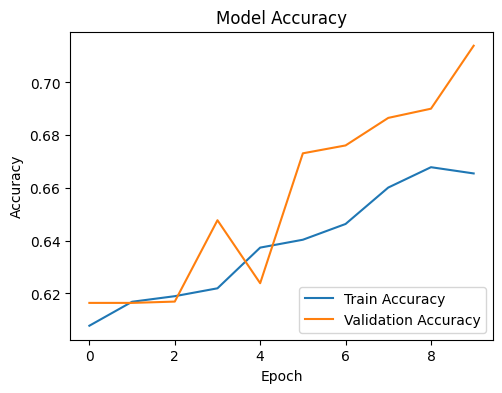

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')



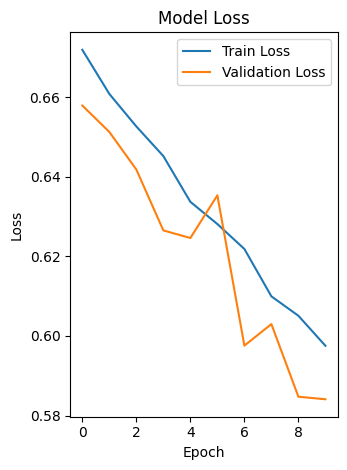

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step


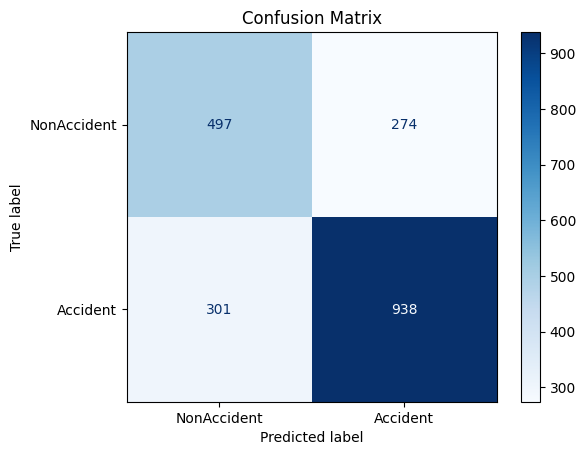

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convert probabilities to binary predictions (0 or 1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#save the model

from tensorflow.keras.models import load_model


model.save(os.path.join('models','ResNet50.h5'))

import os
from tensorflow.keras.models import load_model

# Assuming the model was saved as 'imageclassifier.h5' in the 'models' directory
new_model = load_model(os.path.join('models','ResNet50.h5'))